***

Profesor: Gonzalo A. Ruz, PhD

Curso: Aprendizaje Automático

***

In [ ]:
!pip install tensorflow==2.7.0

In [1]:
# Global imports and settings
# Global imports and settings
import keras
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
print("Using Keras",keras.__version__)
print("Using Tensorflow",tensorflow.__version__)
%matplotlib inline

Using Keras 2.9.0
Using Tensorflow 2.9.2


# Clase: Redes neuronales convolucionales


## Contenido

* Redes neuronales convolucionales
* Aumento de datos (Data augmentation)
* Usando redes previamente entrenadas
* Batch normalization

## Convolutional neural nets
* Al procesar datos de imágenes, queremos descubrir patrones 'locales' (entre píxeles cercanos)
    * bordes, líneas, estructuras
* Considerar *ventanas* (o *patches*) de pixeles (ej. 5x5)

![](https://drive.google.com/uc?id=19Su1qmfQ4yLbLxA4XpXm8lxsGtcJhK-U)

### Convolution
* Deslizar un *filtro* (o *kernel*)  $n$ x $n$ sobre *patches* $n$ x $n$ del mapa de características de entrada
* Reemplazar los valores de píxeles con la convolución del kernel con el parche de imagen subyacente

![](https://drive.google.com/uc?id=1BKYiu9hOVPKpzoun-Gry7WVc1El3aP4h)

* La operación de convolución en sí toma la suma de los valores del producto a nivel de elementos del parche de imagen con el kernel

``` python
def apply_kernel(center, kernel, orig_image):
    image_patch = orig_image[window_slice(center, kernel)]
    # An element-wise multiplication followed by the sum
    return np.sum(kernel * image_patch)
```

![](https://drive.google.com/uc?id=1uLzW-F_IH9MkGSuQAWItGMozQrPS0Y_g)

![](https://drive.google.com/uc?id=1OQPsqikuZhbNzG2R8QB5wTMrW87eKqe-)

In [2]:
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from skimage import color


# Visualize convolution. See https://tonysyu.github.io/
def iter_pixels(image):
    """ Yield pixel position (row, column) and pixel intensity. """
    height, width = image.shape[:2]
    for i in range(height):
        for j in range(width):
            yield (i, j), image[i, j]
            
# Visualize result
def imshow_pair(image_pair, titles=('', ''), figsize=(10, 5), **kwargs):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    for ax, img, label in zip(axes.ravel(), image_pair, titles):
        ax.imshow(img, **kwargs)
        ax.set_title(label)
        
# Zero-padding
def padding_for_kernel(kernel):
    """ Return the amount of padding needed for each side of an image.

    For example, if the returned result is [1, 2], then this means an
    image should be padded with 1 extra row on top and bottom, and 2
    extra columns on the left and right.
    """
    # Slice to ignore RGB channels if they exist.
    image_shape = kernel.shape[:2]
    # We only handle kernels with odd dimensions so make sure that's true.
    # (The "center" pixel of an even number of pixels is arbitrary.)
    assert all((size % 2) == 1 for size in image_shape)
    return [(size - 1) // 2 for size in image_shape]
def add_padding(image, kernel):
    h_pad, w_pad = padding_for_kernel(kernel)
    return np.pad(image, ((h_pad, h_pad), (w_pad, w_pad)),
                  mode='constant', constant_values=0)
def remove_padding(image, kernel):
    inner_region = []  # A 2D slice for grabbing the inner image region
    for pad in padding_for_kernel(kernel):
        slice_i = slice(None) if pad == 0 else slice(pad, -pad)
        inner_region.append(slice_i)
    return image[inner_region]

# Slice windows
def window_slice(center, kernel):
    r, c = center
    r_pad, c_pad = padding_for_kernel(kernel)
    # Slicing is (inclusive, exclusive) so add 1 to the stop value
    return [slice(r-r_pad, r+r_pad+1), slice(c-c_pad, c+c_pad+1)]

# Apply convolution kernel to image patch
def apply_kernel(center, kernel, original_image):
    image_patch = original_image[window_slice(center, kernel)]
    # An element-wise multiplication followed by the sum
    return np.sum(kernel * image_patch)

# Move kernel over the image
def iter_kernel_labels(image, kernel):
    original_image = image
    image = add_padding(original_image, kernel)
    i_pad, j_pad = padding_for_kernel(kernel)

    for (i, j), pixel in iter_pixels(original_image):
        # Shift the center of the kernel to ignore padded border.
        i += i_pad
        j += j_pad
        mask = np.zeros(image.shape, dtype=int)  # Background = 0
        mask[window_slice((i, j), kernel)] = kernel   # Kernel = 1
        #mask[i, j] = 2                           # Kernel-center = 2
        yield (i, j), mask

# Visualize kernel as it moves over the image
def visualize_kernel(kernel_labels, image):
    return kernel_labels + image #color.label2rgb(kernel_labels, image, bg_label=0)

# Do a single step
def convolution_demo(image, kernel, **kwargs):
    # Initialize generator since we're only ever going to iterate over
    # a pixel once. The cached result is used, if we step back.
    gen_kernel_labels = iter_kernel_labels(image, kernel)

    image_cache = []
    image_padded = add_padding(image, kernel)
    # Plot original image and kernel-overlay next to filtered image.
    @interact(i_step=(0, image.size-1,1))
    def convolution_step(i_step=0):
        # Create all images up to the current step, unless they're already
        # cached:
        while i_step >= len(image_cache):

            # For the first step (`i_step == 0`), the original image is the
            # filtered image; after that we look in the cache, which stores
            # (`kernel_overlay`, `filtered`).
            filtered_prev = image_padded if i_step == 0 else image_cache[-1][1]
            # We don't want to overwrite the previously filtered image:
            filtered = filtered_prev.copy()

            # Get the labels used to visualize the kernel
            center, kernel_labels = next(gen_kernel_labels)
            # Modify the pixel value at the kernel center
            filtered[center] = apply_kernel(center, kernel, image_padded)
            # Take the original image and overlay our kernel visualization
            kernel_overlay = visualize_kernel(kernel_labels, image_padded)
            # Save images for reuse.
            image_cache.append((kernel_overlay, filtered))

        # Remove padding we added to deal with boundary conditions
        # (Loop since each step has 2 images)
        image_pair = [remove_padding(each, kernel)
                      for each in image_cache[i_step]]
        imshow_pair(image_pair, **kwargs)
        plt.show()

    return convolution_step

* Diferentes kernels pueden detectar diferentes tipos de patrones en la imagen.

In [3]:
horizontal_edge_kernel = np.array([[ 1,  2,  1],
                                   [ 0,  0,  0],
                                   [-1, -2, -1]])
diagonal_edge_kernel = np.array([[1, 0, 0],
                                 [0, 1, 0],
                                 [0, 0, 1]])
edge_detect_kernel = np.array([[-1, -1, -1],
                               [-1,  8, -1],
                               [-1, -1, -1]])

In [ ]:
plt.subplot(1, 3, 1)
plt.title("Horizontal edge kernel")
plt.imshow(horizontal_edge_kernel, cmap='gray_r')
plt.subplot(1, 3, 2)
plt.title("Diagonal edge kernel")
plt.imshow(diagonal_edge_kernel, cmap='gray_r')
plt.subplot(1, 3, 3)
plt.title("Edge detect kernel")
plt.imshow(edge_detect_kernel, cmap='gray_r')
plt.tight_layout();

Demostración: filtro de borde horizontal
* Responde solo a los bordes horizontales, sensible a la 'dirección' del borde

In [ ]:
# Simple image, just a white box
bright_square = np.zeros((10, 10), dtype=float)
bright_square[2:8, 2:8] = 1

titles = ('Image and kernel', 'Filtered image')
demo = convolution_demo(bright_square, horizontal_edge_kernel,
                        vmin=-4, vmax=4, titles=titles, cmap='gray_r')

In [ ]:
demo(i_step=99)

In [ ]:
pip install openml

In [ ]:
import openml as oml
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
# Get the predictors X and the labels y
X, y, c, a = mnist_data.get_data(dataset_format='array', target=mnist_data.default_target_attribute); 
image = X[1].reshape((28, 28))
image = (image - np.min(image))/np.ptp(image) # Normalize
imgplot=plt.imshow(image, cmap='gray_r')

Demostración MNIST: filtro de borde diagonal

In [ ]:
demo3 = convolution_demo(image, diagonal_edge_kernel,
                 vmin=-4, vmax=4, cmap='gray_r');

In [ ]:
demo3(i_step=783)

Demostración MNIST: filtro de detección de bordes

In [ ]:
demo4 = convolution_demo(image, edge_detect_kernel,
                 vmin=-4, vmax=4, cmap='gray_r');

In [ ]:
demo4(i_step=783)

### Convolución de imágenes en la práctica
* Las convoluciones siempre se han utilizado para preprocesar datos de imágenes
* Se ejecutaron *familias* de kernels en cada imagen (por ejemplo, [filtros de Gabor](https://en.wikipedia.org/wiki/Gabor_filter))

In [ ]:
from scipy import ndimage as ndi
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

# Gabor Filters.
@interact
def demoGabor(frequency=(0.01,1,0.05), theta=(0,3.14,0.1), sigma=(0,5,0.1)):
    plt.gray()
    plt.imshow(np.real(gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)), interpolation='nearest')

In [ ]:
demoGabor(frequency=0.86, theta=1.9, sigma=1.7)

In [15]:
### Gabor filters applied to Fashion-MNIST example
### Just for illustration. Can be removed in the final submission.
### Careful, it takes a few seconds to do the convolution
# Calculate the magnitude of the Gabor filter response given a kernel and an imput image
def magnitude(image, kernel):
    image = (image - image.mean()) / image.std() # Normalize images
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

### Demostración sobre los datos de MNIST

In [ ]:
@interact
def demoGabor2(frequency=(0.01,1,0.05), theta=(0,3.14,0.1), sigma=(0,5,0.1)):
    plt.subplot(131)
    plt.title('Original')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Gabor kernel')
    plt.imshow(np.real(gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)), interpolation='nearest')
    plt.subplot(133)
    plt.title('Response magnitude')
    plt.imshow(np.real(magnitude(image, gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))), interpolation='nearest')

In [ ]:
demoGabor2(frequency=0.96, theta=1.7, sigma=0.3)

In [18]:
fmnist_data = oml.datasets.get_dataset(40996) # Download FMNIST data
# Get the predictors X and the labels y
X, y, c, a = fmnist_data.get_data(dataset_format='array', target=fmnist_data.default_target_attribute); 

* También funciona para imágenes generales.
* Ejemplo de juguete: Fashion-MNIST

In [ ]:
# build a list of figures for plotting
def buildFigureList(fig, subfiglist, titles, length):
    for i in range(0,length):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(1,length,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.set_title(titles[i], fontsize=6)
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

subfiglist = []
titles=[]

for i in range(0,10):
    subfiglist.append(X[i])
    titles.append(i)

buildFigureList(plt.figure(1),subfiglist, titles, 10)
plt.show()

boot = X[0].reshape((28, 28))

Demostración: Moda MNIST

In [ ]:
image=boot
@interact
def demoGabor2(frequency=(0.01,1,0.05), theta=(0,3.14,0.1), sigma=(0,5,0.1)):
    plt.subplot(131)
    plt.title('Original')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Gabor kernel')
    plt.imshow(np.real(gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)), interpolation='nearest')
    plt.subplot(133)
    plt.title('Response magnitude')
    plt.imshow(np.real(magnitude(image, gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))), interpolation='nearest')

In [ ]:
demoGabor2(frequency=0.81, theta=2.7, sigma=0.9)

Fashion MNIST con múltiples filtros (banco de filtros)

In [ ]:
# Fetch some Fashion-MNIST images
boot = X[0].reshape(28, 28)
shirt = X[1].reshape(28, 28)
dress = X[2].reshape(28, 28)
image_names = ('boot', 'shirt', 'dress')
images = (boot, shirt, dress)

plt.rcParams['figure.dpi'] = 80

# Create a set of kernels, apply them to each image, store the results
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        for sigma in (1, 3):
            kernel = gabor_kernel(frequency, theta=theta,sigma_x=sigma,sigma_y=sigma)
            params = 'theta=%.2f,\nfrequency=%.2f\nsigma=%.2f' % (theta, frequency, sigma)
            kernel_params.append(params)
            results.append((kernel, [magnitude(img, kernel) for img in images]))

# Plotting
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(6, 12))
plt.gray()
#fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)
axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, magnitudes), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest') # Plot kernel
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([]) # Remove axis ticks 
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(magnitudes)
    vmax = np.max(magnitudes)
    for patch, ax in zip(magnitudes, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax) # Plot convolutions
        ax.axis('off')

plt.show();

plt.rcParams['figure.dpi'] = 120

### Capas convolucionales: mapas de características

![](https://drive.google.com/uc?id=1QWb0OOLdne93PpytUI2kZR370PosmPYI)

* Deslizamos $d$ filtros a través de la imagen de entrada en paralelo, produciendo una salida (1x1xd) por parche, reensamblada en el *mapa de características* final con $d$ 'canales', un tensor (ancho x alto x d).
* Los filtros se inicializan aleatoriamente, queremos *aprender* los valores óptimos para los datos de entrada


### Efectos de borde
* Considere una imagen de 5x5 y un filtro de 3x3: solo hay 9 ubicaciones posibles, por lo tanto, el resultado es un mapa de características de 3x3
* Si queremos mantener el tamaño de la imagen, usamos *zero-padding*, agregando ceros alrededor del tensor de entrada.

![](https://drive.google.com/uc?id=1Xd1yQceFvH-8gsyGBfe_cVieGUzLebLr)

![](https://drive.google.com/uc?id=1w-N5SE7hratjdHCDDucFf81bwmx-NQ81)

### Submuestreo
* A veces, queremos reducir la resolución (*downsample*) de una imagen de alta resolución
    * Procesamiento más rápido, menos ruidoso (por lo tanto, menos sobreajuste)
* Un enfoque es _saltarse_ valores durante la convolución
    * Distancia entre 2 ventanas: *stride length*
* Ejemplo con stride length 2 (sin padding):
    
![](https://drive.google.com/uc?id=1ddMMYjlPaAfh8kjBsQEj9a0U8N8AmjL2)

### Max-pooling
* Otro enfoque para reducir los tensores de entrada es *max-pooling*:
    - Ejecute un filtro con una longitud de zancada (stride length) fija sobre la imagen
        - Usualmente filtros de 2x2 y stride lenght 2
    - El filtro devuelve el *max* (o *avg*) de todos los valores
* Reduce agresivamente el número de pesos (menos sobreajuste)
* La información de cada nodo de entrada se propaga más rápidamente a los nodos de salida
    - En convnets `puras`, un valor de entrada se extiende a 3x3 nodos de la primera capa, 5x5 nodos de la segunda, etc.
    - Necesitaría redes mucho más profundas, que son mucho más difíciles de entrenar.

![](https://drive.google.com/uc?id=1Jinu6iEUdPCu3Kk4yJFnhVf7Ihq9bDfA)

## Redes convolucionales en la práctica
* Modelemos MNIST nuevamente, esta vez usando convnets
* `Conv2D` para 2D convolutional layers
    - Default: 32 filtros, inicializados aleatoriamente (de distribución uniforme)
* `MaxPooling2D` para max-pooling
    - 2x2 pooling reduce el número de entradas en un factor 4
        
``` python
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
```

In [23]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Observe cómo la imagen de entrada se reduce a un mapa de características de 3x3x64

In [ ]:
model.summary()

Compare con la arquitectura sin max-pooling:
* Output layer is a 22x22x64 feature map!

In [ ]:
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu',
                      input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.summary()

* Para clasificar las imágenes, todavía necesitamos las caspas Dense y Softmax.
* Necesitamos aplanar el mapa de características de 3x3x64 a un vector de tamaño 576

``` python
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
```

In [26]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

* Entrene y pruebe como de costumbre
* Compare con la accuracy del 97,8% de la arquitectura densa anterior

``` python
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(test_images, test_labels)
```

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=0)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Accuracy: ", test_acc)

## Convnets en pequeños conjuntos de datos
* Pasemos a un conjunto de datos más realista: Cats vs Dogs
    - Tomamos una submuestra equilibrada de 4000 imágenes en colores reales. 
    - 2000 para entrenamiento, 1000 para validación, 1000 para prueba
* Las convnets aprenden patrones locales, lo cual es muy eficiente
* *Translation invariant*: un patrón se puede reconocer incluso si se cambia a otra parte de la imagen
    - Más robusto, eficiente para entrenar (con menos ejemplos)
* Podemos usar trucos como *data augmentation*
* Podemos reutilizar redes _pre-entrenadas_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [31]:
base_dir = '/content/drive/My Drive/data/cats-vs-dogs_small'
model_dir = '/content/drive/My Drive/data/models'

### Preprocesamiento de datos
* Usamos ImageDataGenerator de Keras para:
    * Decodificar imágenes JPEG en tensores de punto flotante
    * Cambiar la escala de los valores de píxeles a [0,1]
    * Cambiar el tamaño de las imágenes a 150x150 píxeles
* Devuelve un *generador* de Python que podemos consultar infinitamente por imágenes
    * Lotes de 20 imágenes por consulta
* Por separado para conjunto de entrenamiento, validación y prueba

``` python
train_generator = train_datagen.flow_from_directory(
        train_dir, # Directory with images
        target_size=(150, 150), # Resize images 
        batch_size=20, # Return 20 images at a time
        class_mode='binary') # Binary labels
```

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

base_dir = '/content/drive/My Drive/data/cats-vs-dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Construir desde 0

``` python
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))



```

In [34]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

### Entrenamiento

* 100 pasos por época (de 20 imágenes cada una), durante 30 épocas
* También proporciona un generador para los datos de validación.
    
``` python
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])
history = model.fit(
      train_generator, steps_per_epoch=100,
      epochs=30, verbose=0,
      validation_data=validation_generator,
      validation_steps=50)
```

* El entrenamiento tarda unos 30 minutos aprox. (en CPU)
* Guardamos el modelo entrenado (y el historial) para poder volver a cargarlo más tarde

``` python
model.save(os.path.join(model_dir, 'cats_and_dogs_small_1.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_1_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
```

In [ ]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
#Tarda 20-30min aprox. (8 min aprox.usando GPU)
import os
import pickle

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30, verbose=0,
      validation_data=validation_generator,
      validation_steps=50)
model.save(os.path.join(model_dir, 'cats_and_dogs_small_1.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_1_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Nuestro modelo está sobreajustado: necesitamos más ejemplos de entrenamiento, más regularización
![](https://drive.google.com/uc?id=193NpxEuUAyRqwmaFEJfXJCrXZcsYJGSo)

![](https://drive.google.com/uc?id=1x8BTFSTB8CjEfEF2wbBTKQc104V1Et7c)

In [ ]:
#Usted puede generar los gráficos de arriba si realiza su propio entrenamiento

import pickle

history = pickle.load(open("/content/drive/My Drive/data/models/cats_and_dogs_small_1_history.p", "rb"))

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Data augmentation
* Genere nuevas imágenes mediante transformaciones de imágenes
    - Rotation, translation, shear, zoom, horizontal flip,...
* Keras tiene una herramienta para esto:
    
``` python
datagen = ImageDataGenerator(
      rotation_range=40, width_shift_range=0.2,
      height_shift_range=0.2, shear_range=0.2,
      zoom_range=0.2, horizontal_flip=True,
      fill_mode='nearest')
```

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Ejemplo

In [ ]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image
plt.rcParams['figure.dpi'] = 120

train_cats_dir = os.path.join(base_dir, 'train', 'cats')
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[5]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
for a in range(2):
    i = 0
    for batch in datagen.flow(x, batch_size=1):
        plt.subplot(141+i) 
        plt.xticks([]) 
        plt.yticks([])
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 4 == 0:
            break
        
    plt.tight_layout()
    plt.show()

También agregamos Dropout antes de la capa Dense

``` python
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
```

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


###### El entrenamiento dura aproximadamente 1.5 horas en la CPU

``` python
history = model.fit(
      train_generator,
      epochs=100,  verbose=0,
      validation_data=validation_generator)
model.save(os.path.join(model_dir, 'cats_and_dogs_small_2.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_2_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
```

In [ ]:
#Tarda 1.5 hrs aprox. (36 min aprox. con GPU)

history = model.fit(
      train_generator,
      epochs=100,  verbose=1,
      validation_data=validation_generator)
model.save(os.path.join(model_dir, 'cats_and_dogs_small_2.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_2_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/100
63/63 [==============================] - 23s 340ms/step - loss: 0.6947 - acc: 0.5150 - val_loss: 0.6873 - val_acc: 0.5790
Epoch 2/100
63/63 [==============================] - 21s 337ms/step - loss: 0.6875 - acc: 0.5555 - val_loss: 0.7469 - val_acc: 0.5000
Epoch 3/100
63/63 [==============================] - 23s 360ms/step - loss: 0.6829 - acc: 0.5540 - val_loss: 0.6645 - val_acc: 0.6160
Epoch 4/100
63/63 [==============================] - 21s 337ms/step - loss: 0.6748 - acc: 0.5665 - val_loss: 0.6571 - val_acc: 0.5840
Epoch 5/100
63/63 [==============================] - 21s 336ms/step - loss: 0.6663 - acc: 0.5885 - val_loss: 0.6451 - val_acc: 0.6280
Epoch 6/100
63/63 [==============================] - 22s 342ms/step - loss: 0.6584 - acc: 0.5915 - val_loss: 0.6953 - val_acc: 0.5340
Epoch 7/100
63/63 [==============================] - 21s 339ms/step - loss: 0.6506 - acc: 0.6155 - val_loss: 0.6357 - val_acc: 0.6250
Epoch 8/100
63/63 [==============================] - 22s 348ms

¡(Casi) no más sobreajuste!

![](https://drive.google.com/uc?id=1zZGLQCLEr5F9halIbMRS_03ZU747_ksG)

![](https://drive.google.com/uc?id=19uD1zMSbzX-lEvZSyK3degufVhqndtUe)

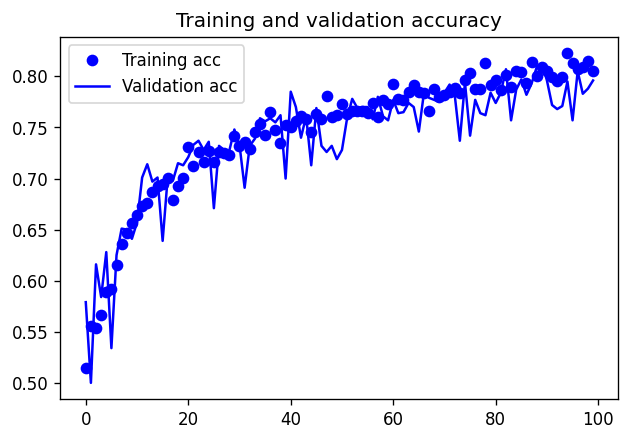

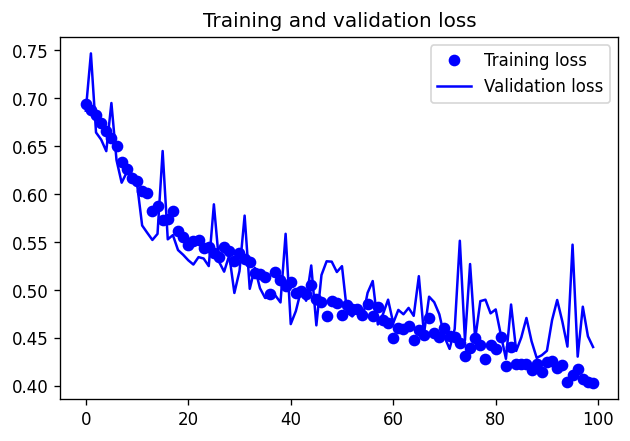

In [ ]:
#Usted puede generar los gráficos de arriba si realiza su propio entrenamiento

import pickle

history = pickle.load(open("/content/drive/My Drive/data/models/cats_and_dogs_small_2_history.p", "rb"))

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Visualizando las salidas intermedias
* Veamos qué está aprendiendo exactamente la convnet observando los mapas de características intermedias
    - La salida de una capa también se denomina *activación*
* Dado que nuestros mapas de características tienen una profundidad de 32/64/128, necesitamos visualizar *todas* 
* Elegimos una imagen de entrada específica y observamos las salidas

In [ ]:
from tensorflow.keras.models import load_model
import os

model = load_model(os.path.join(model_dir, 'cats_and_dogs_small_2.h5'))
model.summary()  # As a reminder.

In [ ]:
img_path = os.path.join(base_dir, 'test/cats/cat.1700.jpg')

# We preprocess the image into a 4D tensor
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) 
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [41]:
from tensorflow.keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 207ms/step


* Creamos un nuevo modelo que está compuesto por las primeras 8 capas (la parte convolucional)
* Ingresamos nuestra imagen de ejemplo y leemos la salida

``` python
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
```

Salida de la primera capa Conv2D, cuarto canal (filtro):
* Similar a un detector de borde diagonal
* Los canales de ustedes pueden verse diferentes

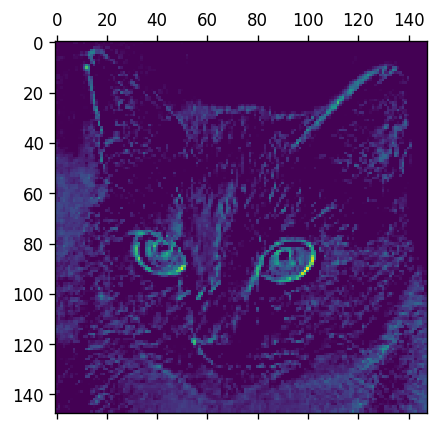

In [43]:
plt.rcParams['figure.dpi'] = 120
first_layer_activation = activations[0]

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.show()

Salida del canal 22 (filtro):
* ¿Detector de ojos de gato?

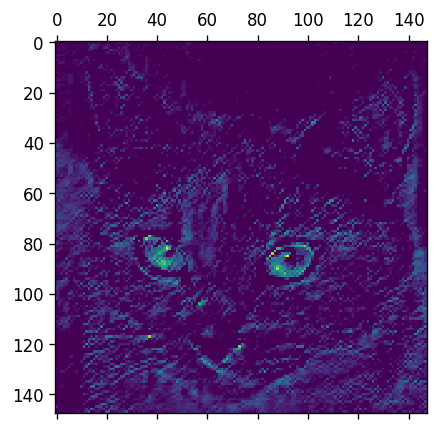

In [ ]:
plt.matshow(first_layer_activation[0, :, :,22], cmap='viridis')
plt.show()

In [ ]:
images_per_row = 16

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

def plot_activations(start, end):
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

* Primeras 2 capas convolucionales: varios detectores de bordes

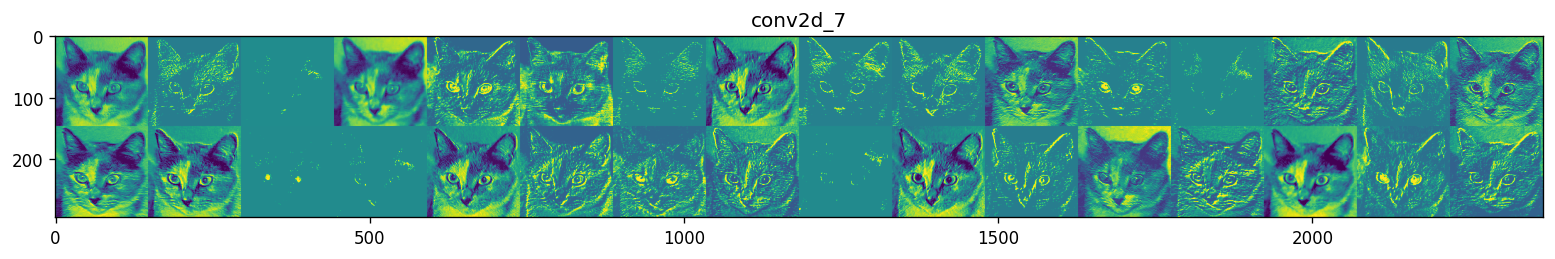

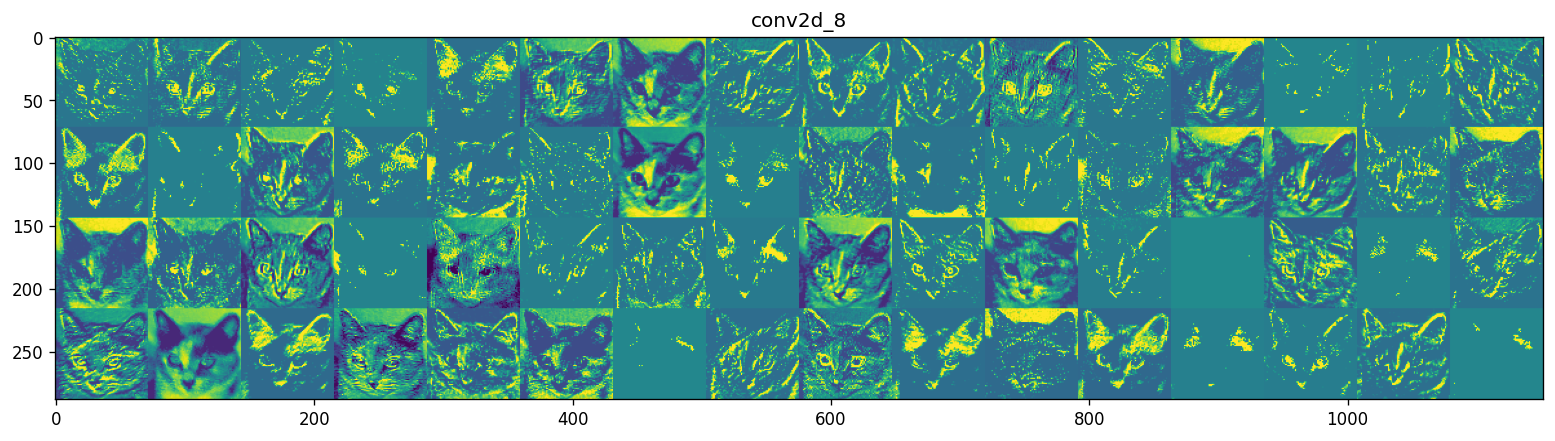

In [ ]:
plot_activations(0,1)
plot_activations(2,3)

* 3a capa convolucional: cada vez más abstracta: oídos, ojos

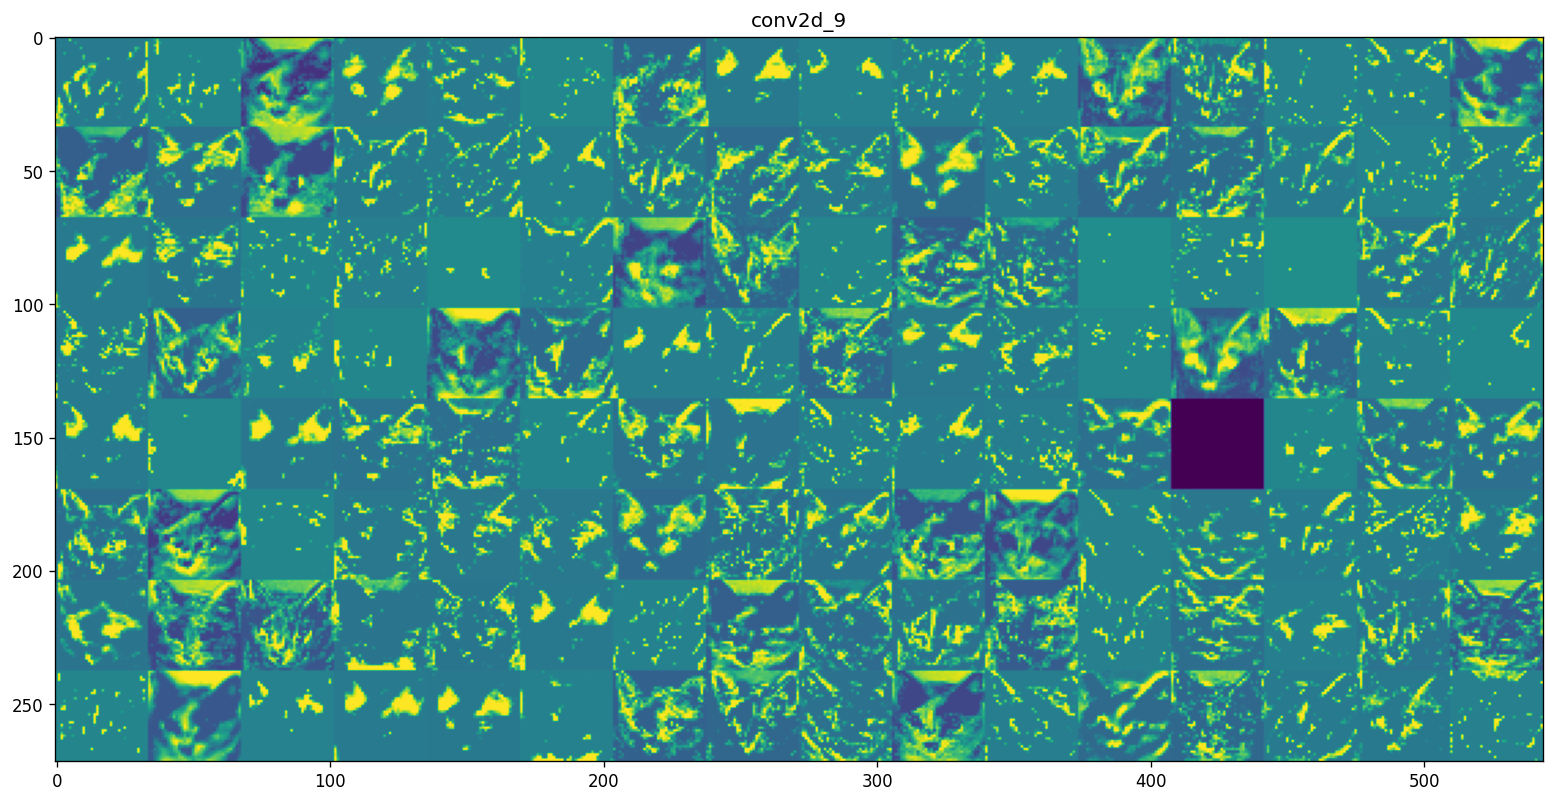

In [ ]:
plot_activations(4,5)

* Última capa convolucional: sparsity creciente. Los patrones aprendidos no existen en los datos de entrenamiento

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


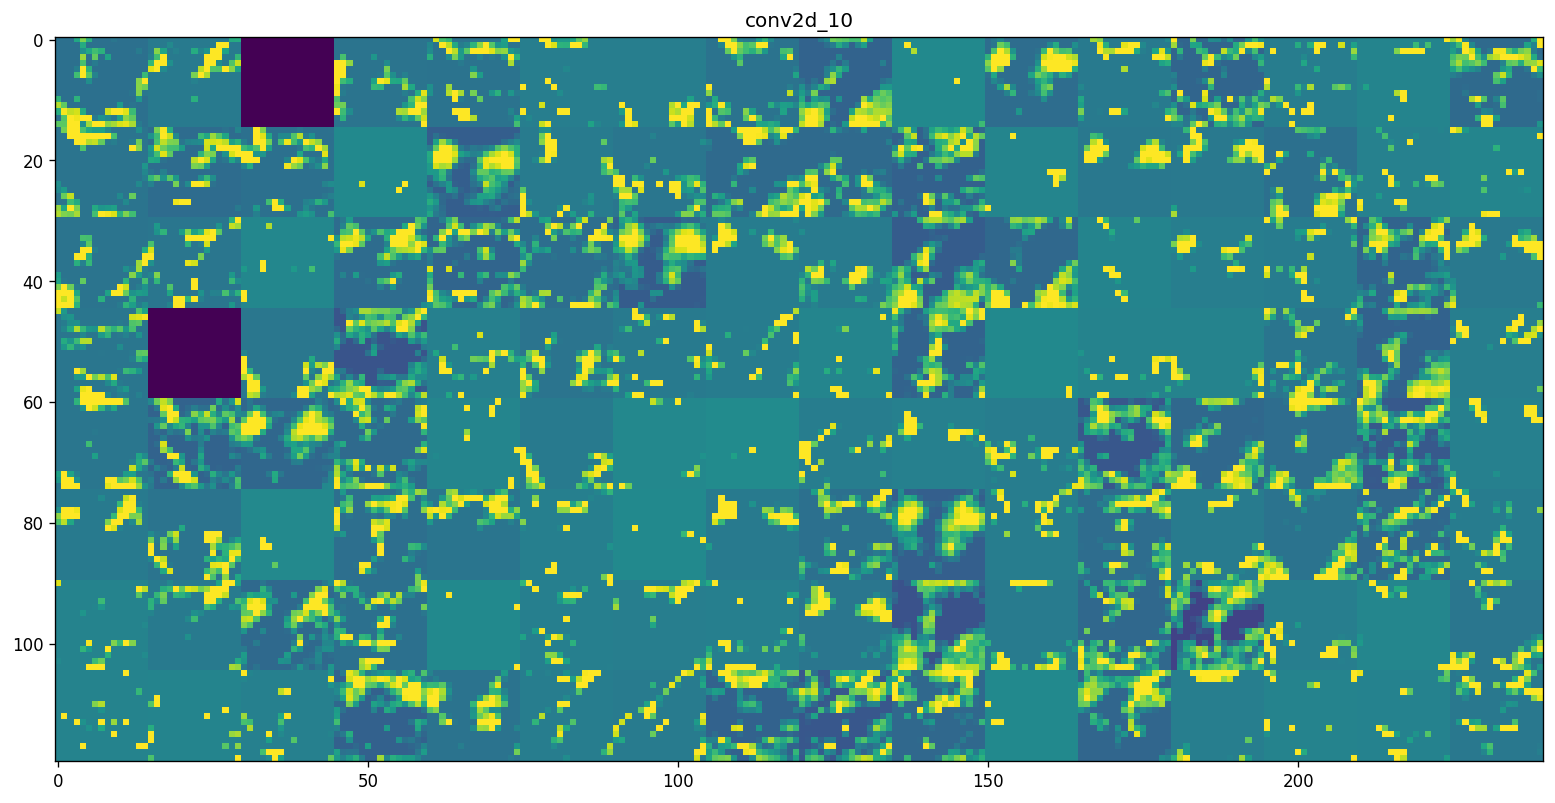

In [ ]:
plot_activations(6,7)

### Jerarquías espaciales
* Las deep convnets pueden aprender *jerarquías espaciales* de patrones
    - La primera capa puede aprender patrones muy locales (por ejemplo, bordes)
    - La segunda capa puede aprender combinaciones específicas de patrones.
    - Cada capa puede aprender *abstracciones* cada vez más complejas
    
![](https://drive.google.com/uc?id=1Yi6GIfIZQaOJZa5uOkEKK_WsW2KPxmPN)

### Visualizando los filtros aprendidos
* Los filtros en sí se pueden visualizar al encontrar la imagen de entrada a la que responden al máximo.
* *ascenso del gradiente en el espacio de entrada*: comience desde una imagen en blanco, use la pérdida para actualizar los valores de los píxeles a valores a los que el filtro responde con más fuerza

``` python
    from tensorflow.keras import backend as K
    input_img = np.random.random((1, size, size, 3)) * 20 + 128.
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0] # Compute gradient
    for i in range(40): # Run gradient ascent for 40 steps
        loss_v, grads_v = K.function([input_img], [loss, grads])
        input_img_data += grads_v * step
```

In [55]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [56]:
# Convert tensor to image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Hagamos esto para la red `VGG16` previamente entrenada en` ImageNet`
``` python
model = VGG16(weights='imagenet', include_top=False)
```

In [ ]:
# VGG16 model
model.summary()

In [58]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

* Visualice los filtros de convolución 0-2 de la capa 5 de la red VGG entrenada en ImageNet

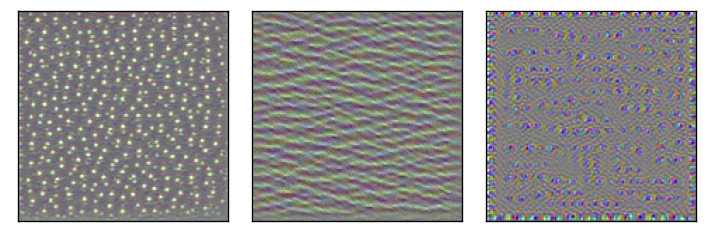

In [59]:
for i in range(3):
    plt.subplot(131+i) 
    plt.xticks([]) 
    plt.yticks([])
    plt.imshow(generate_pattern('block3_conv1', i))
plt.tight_layout()
plt.show();

In [ ]:
def visualize_filter(layer_name):
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(10, 10))
    plt.imshow((results * 255).astype(np.uint8))

    plt.show()

Primeros 64 filtros para la primera capa convolucional en el bloque 1: bordes y colores simples

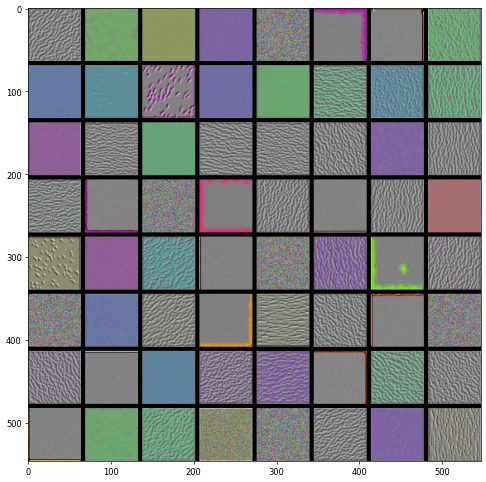

In [ ]:
plt.rcParams['figure.dpi'] = 60
visualize_filter('block1_conv1')

Filtros en el segundo bloque de capas de convolución: texturas simples (bordes y colores combinados)

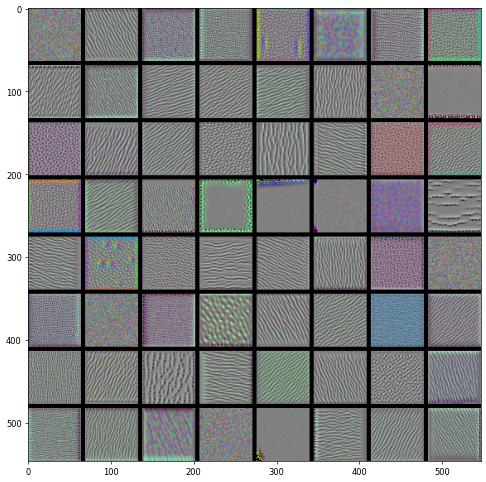

In [ ]:
visualize_filter('block2_conv1')

Filtros en el tercer bloque de capas de convolución: texturas más naturales

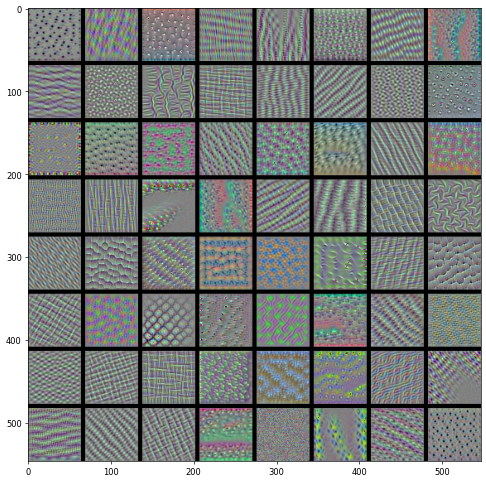

In [ ]:
visualize_filter('block3_conv1')

Filtros en 4to bloque de capas de convolución: plumas, ojos, hojas, ...

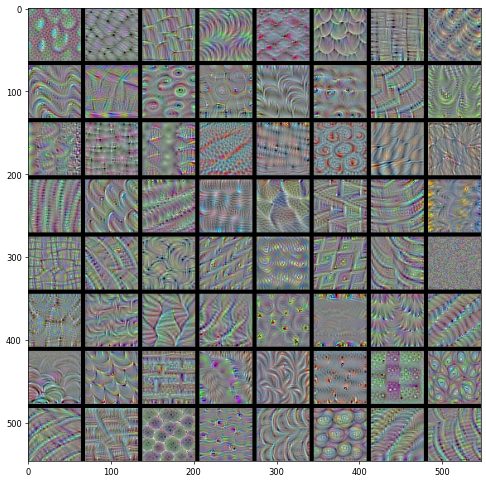

In [ ]:
visualize_filter('block4_conv1')

## Usando redes pre-entrenadas
* Podemos reutilizar redes previamente entrenadas en lugar de entrenar desde cero
* Las características aprendidas pueden ser un modelo genérico del mundo visual
* Utilice *convolutional base* para construir características, luego entrenar cualquier clasificador en nuevos datos

![](https://drive.google.com/uc?id=1lYkdAv2SK6wTsmeaCVshxgf8nXBmVp7K)

* Creemos una instancia del modelo VGG16 (sin las capas densas)
* El mapa de características final tiene forma (4, 4, 512)
``` python
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
```

In [ ]:
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(150, 150, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Uso de redes previamente entrenadas: 3 formas
* Extracción rápida de características sin data augmentation
    - Llamar a `predict` desde la convolutional base
    - Utilice los resultados para entrenar una red neuronal densa
* Extracción de características con data augmentation
    - Extienda el modelo base convolucional con una capa densa
    - Ejecútelo de un extremo a otro con los nuevos datos (¡caro!)
* Fine-tuning
    - Haz cualquiera de los dos anteriores para entrenar a un clasificador
    - Descongele algunas de las capas convolucionales superiores
        - Actualiza solo las representaciones más abstractas
    - Entrene conjuntamente todas las capas en los nuevos datos

### Extracción rápida de características sin data augmentation
* Extraer imágenes filtradas y sus etiquetas
    - Puede volver a utilizar un generador de datos
    
``` python
generator = datagen.flow_from_directory(dir, target_size=(150, 150),
        batch_size=batch_size, class_mode='binary')
for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
```

In [ ]:
#tarda 3-4 min aprox.
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Tener en cuenta que dado que los generadores producen datos 
            # indefinidamente en un bucle, debemos hacer un'break' después 
            # de que cada imagen haya sido vista una vez.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

* Construir una red neuronal densa (con Dropout)
* Entrena y evalúa con los ejemplos transformados

``` python
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
```

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30, verbose=1,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 8ms/step - loss: 0.5844 - acc: 0.6830 - val_loss: 0.4322 - val_acc: 0.8310
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4214 - acc: 0.8120 - val_loss: 0.3519 - val_acc: 0.8680
Epoch 3/30
100/100 [==============================] - 1s 8ms/step - loss: 0.3410 - acc: 0.8535 - val_loss: 0.3390 - val_acc: 0.8480
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3108 - acc: 0.8655 - val_loss: 0.2982 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2871 - acc: 0.8795 - val_loss: 0.2777 - val_acc: 0.8860
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2651 - acc: 0.8985 - val_loss: 0.2731 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2436 - acc: 0.9050 - val_loss: 0.2622 - val_acc: 0.8920
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - loss: 0.

* Accuracy en validación alrededor del 90%, ¡mucho mejor!
* Aún sobreajustado, a pesar de estar usando Dropout: no hay suficientes datos de entrenamiento

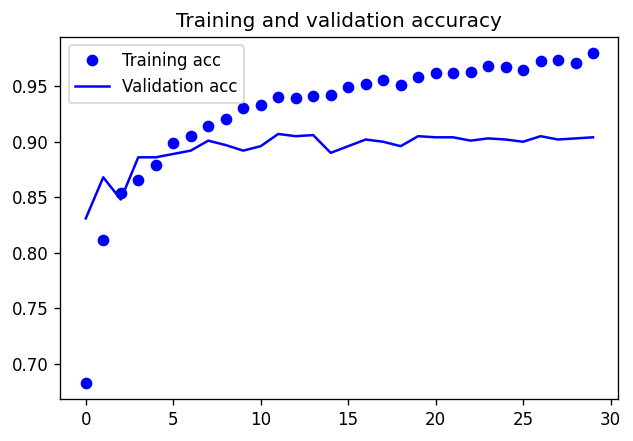

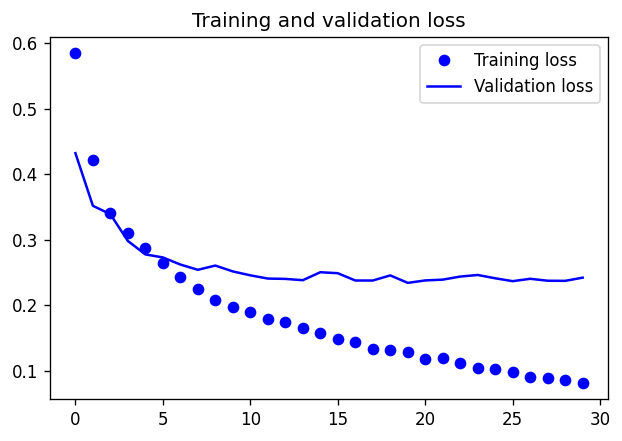

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Extracción de características con data augmentation
* Use data augmentation para obtener más datos de entrenamiento
* Simplemente agregue las capas densas a la base convolucional
* *Congelar (freeze)* la convolutional base (antes de compilar)

``` python
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False
```

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### Toma mucho tiempo en CPU.
``` python
history = model.fit(
      train_generator,
      epochs=30,
      validation_data=validation_generator,
      verbose=0)
```

Data augmentation y entrenamiento 
``` python
train_datagen = ImageDataGenerator(
      rescale=1./255, rotation_range=40, width_shift_range=0.2,
      height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
      horizontal_flip=True, fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(dir,
      target_size=(150, 150), batch_size=20, class_mode='binary')
history = model.fit(
      train_generator, epochs=30,
      validation_data=validation_generator)
model.save(os.path.join(model_dir, 'cats_and_dogs_small_3.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_3_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
```

In [ ]:
#tarda 14 min aprox. enn GPU

train_datagen = ImageDataGenerator(
      rescale=1./255, 
      rotation_range=40, 
      width_shift_range=0.2,
      height_shift_range=0.2, 
      shear_range=0.2, 
      zoom_range=0.2,
      horizontal_flip=True, 
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')

history = model.fit(
      train_generator, epochs=30,
      validation_data=validation_generator)

model.save(os.path.join(model_dir, 'cats_and_dogs_small_3.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_3_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Found 2000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 20.0000 - loss: 0.5887 - acc: 0.6915

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


100/100 [==============================] - 31s 285ms/step - batch: 49.5000 - size: 20.0000 - loss: 0.5887 - acc: 0.6915 - val_loss: 0.4375 - val_acc: 0.8370
Epoch 2/30
100/100 [==============================] - 28s 277ms/step - batch: 49.5000 - size: 20.0000 - loss: 0.4894 - acc: 0.7785 - val_loss: 0.3670 - val_acc: 0.8670
Epoch 3/30
100/100 [==============================] - 27s 276ms/step - batch: 49.5000 - size: 20.0000 - loss: 0.4331 - acc: 0.8095 - val_loss: 0.3400 - val_acc: 0.8620
Epoch 4/30
100/100 [==============================] - 28s 277ms/step - batch: 49.5000 - size: 20.0000 - loss: 0.4045 - acc: 0.8260 - val_loss: 0.3042 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 28s 277ms/step - batch: 49.5000 - size: 20.0000 - loss: 0.3842 - acc: 0.8305 - val_loss: 0.2983 - val_acc: 0.8860
Epoch 6/30
100/100 [==============================] - 28s 281ms/step - batch: 49.5000 - size: 20.0000 - loss: 0.3743 - acc: 0.8360 - val_loss: 0.2828 - val_acc: 0.8870
Epo

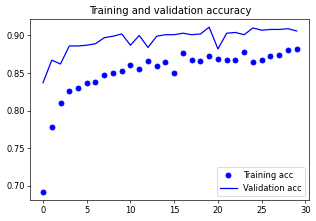

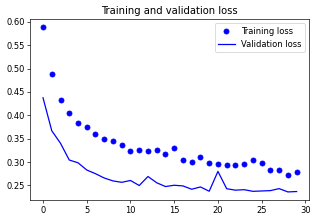

In [ ]:
history = pickle.load(open("/content/drive/My Drive/data/models/cats_and_dogs_small_3_history.p", "rb"))

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Fine-tuning
* Agregue su red personalizada sobre una red base ya entrenada.
* Congele la red base.
* Entrena la parte que agregaste.
* Descongele algunas capas en la red base.
* Entrene conjuntamente ambas capas y la parte que se agregó.

``` python
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    else:
        layer.trainable = False
```

Visualizado

![](https://drive.google.com/uc?id=1XqTdDEZ9bP1HT5YOAjslSy95WSYaUmuP)

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

* Cargue la red entrenada, ajuste
    - Utilice una tasa de aprendizaje pequeña, una gran cantidad de épocas
    - No quieres desaprender demasiado 
    
``` python
model = load_model(os.path.join(model_dir, 'cats_and_dogs_small_3.h5'))
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])
history = model.fit(
      train_generator, epochs=100,
      validation_data=validation_generator)
```

##### Toma harto tiempo el entrenamiento. Si desea correrlo, copie el código en una celda code
``` python
from tensorflow.keras.models import load_model
model = load_model(os.path.join(model_dir, 'cats_and_dogs_small_3.h5'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      epochs=30, # Repeat with epochs=100
      validation_data=validation_generator)
model.save(os.path.join(model_dir, 'cats_and_dogs_small_4.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_4_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
```

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import pickle

model = load_model(os.path.join(model_dir, 'cats_and_dogs_small_3.h5'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      epochs=30, # Repeat with epochs=100
      validation_data=validation_generator)

model.save(os.path.join(model_dir, 'cats_and_dogs_small_4.h5'))
with open(os.path.join(model_dir, 'cats_and_dogs_small_4_history.p'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/30
100/100 [==============================] - 32s 307ms/step - loss: 0.2783 - acc: 0.8830 - val_loss: 0.2378 - val_acc: 0.9100
Epoch 2/30
100/100 [==============================] - 30s 304ms/step - loss: 0.2775 - acc: 0.8855 - val_loss: 0.2348 - val_acc: 0.9080
Epoch 3/30
100/100 [==============================] - 30s 304ms/step - loss: 0.2891 - acc: 0.8750 - val_loss: 0.2381 - val_acc: 0.9060
Epoch 4/30
100/100 [==============================] - 31s 306ms/step - loss: 0.2862 - acc: 0.8850 - val_loss: 0.2352 - val_acc: 0.9030
Epoch 5/30
100/100 [==============================] - 31s 306ms/step - loss: 0.2717 - acc: 0.8820 - val_loss: 0.2432 - val_acc: 0.9040
Epoch 6/30
100/100 [==============================] - 30s 304ms/step - loss: 0.2630 - acc: 0.8930 - val_loss: 0.2337 - val_acc: 0.9120
Epoch 7/30
100/100 [==============================] - 31s 307ms/step - loss: 0.2860 - acc: 0.8690 - val_loss: 0.2345 - val_acc: 0.9090
Epoch 8/30
100/100 [==============================] - 3

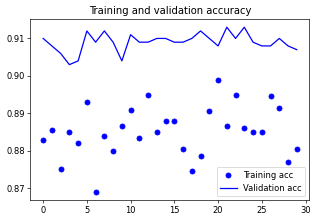

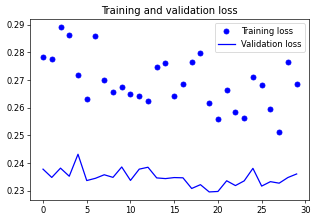

In [ ]:
history = pickle.load(open("/content/drive/My Drive/data/models/cats_and_dogs_small_4_history.p", "rb"))

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* Las curvas de aprendizaje son un poco ruidosas, suavícelas usando un promedio móvil

``` python
def smooth_curve(points, factor=0.8):
  smoothed = []
  for point in points:
    if smoothed:
      previous = smoothed[-1]
      smoothed.append(previous * factor + point * (1 - factor))
    else:
      smoothed.append(point)
  return smoothed
```

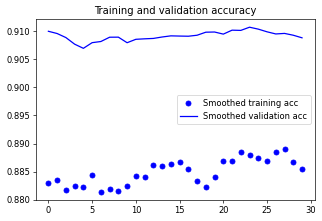

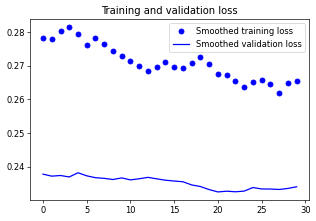

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 7s 130ms/step - loss: 0.2506 - acc: 0.9040
test acc: 0.9039999842643738


## Visualización de la activación de clases
* También podemos visualizar qué parte de la imagen de entrada tuvo la mayor influencia en la clasificación final
    - Útil para interpretar lo aprendido (o clasificado erróneamente)
* *Mapas de activación de clases (Class activation maps)*: produce un mapa de calor sobre la imagen de entrada
    - Tome el mapa de características de salida de una capa de convolución
    - Pese cada canal (filtro) por el gradiente de la clase con respecto al canal
* Encuentra canales importantes, mira qué los activa 

* Pruebe VGG (incluidas las capas densas) y una imagen de ImageNet
``` python
model = VGG16(weights='imagenet')
```
![](https://drive.google.com/uc?id=1WYcHh7dnROwmxVaXRi2IjaUemlJYlgD0)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

K.clear_session()
# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

 [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

* Cargar imagen
* Cambiar el tamaño a 224 x 224 (en qué se entrenó VGG)
* Hacer el mismo preprocesamiento (utilidad Keras VGG)

``` python
from keras.applications.vgg16 import preprocess_input
img_path = '/content/drive/My Drive/data/images/10_elephants.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # Transform to batch of size (1, 224, 224, 3)
x = preprocess_input(x)
```

In [ ]:
## From Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# The local path to our target image
img_path = '/content/drive/My Drive/data/images/10_elephants.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation

heatmap = np.mean(conv_layer_output_value, axis=-1)

* Prueba de cordura: ¿obtenemos la predicción correcta?
    
``` python
preds = model.predict(x)
```

In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.90942174), ('n01871265', 'tusker', 0.086182125), ('n02504013', 'Indian_elephant', 0.004354569)]


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Visualiza el mapa de activación de clases

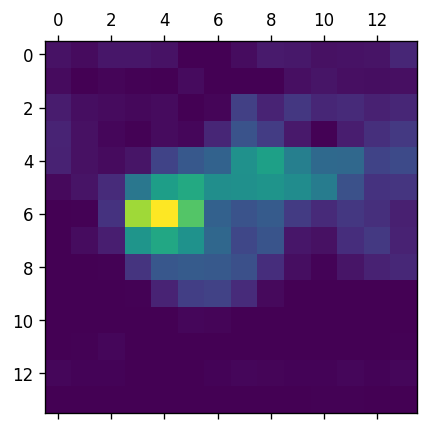

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [ ]:
# pip install opencv-python
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('/content/drive/My Drive/data/images/elephant_cam.jpg', superimposed_img)

True

* Superponer sobre nuestra imagen

![](https://drive.google.com/uc?id=1-1rzjyPnbbChSyRZ2Q8FX5Gu9VPOfGWB)

## Una cosa más: Batch Normalization
* La normalización (en general) tiene como objetivo hacer que diferentes ejemplos sean más similares entre sí
    * Más fácil de aprender y generalizar
* Estandarización (centrando los datos en 0 y escalando a 1 stddev)
    * Esto supone que los datos se distribuyen normalmente.
* La capa Batch normalization normaliza adaptativamente los datos, incluso cuando la media y la varianza cambian con el tiempo durante el entrenamiento.
    * Funciona manteniendo internamente un promedio móvil exponencial de la media por lotes y la varianza de los datos de entrenamiento.
    * Ayuda con la propagación del gradiente, permite redes más profundas.

BatchNormalization layer es típicamente utilizada después de una capa convolucional o una capa densa:

``` python
conv_model.add(layers.Conv2D(32, 3, activation='relu'))
conv_model.add(layers.BatchNormalization())

dense_model.add(layers.Dense(32, activation='relu')) 
dense_model.add(layers.BatchNormalization())
```

## Resumen
* Las Convnets son ideales para atacar problemas de clasificación visual.
* Aprenden una jerarquía de patrones y conceptos modulares para representar el mundo visual.
* Las representaciones son fáciles de inspeccionar
* Data augmentation ayuda a combatir el sobreajuste
* Batch normalization ayuda a entrenar redes más profundas
* Puede utilizar una convnet previamente entrenada para realizar la extracción de características y fine-tuning